# Experiments with a stock price data set

The stock price data set we use in this experiment is a stock market index (composite stock price index of common stocks) in a country for the period between 2000 and 2022, consisting of 
* Four historical prices (‘Open’, ‘High’, ‘Low’, ‘Close’, which denote the opening, highest, lowest, and closing prices on the trading day, respectively)
* Trading volume
* Four technical indicators (RSI, SMA, BBP, ADX),(Relative Strength Index (RSI), Simple Moving Average (SMA), Average Directional Movement Index (ADX) and Bollinger Band Position (BBP). You can read more about these indicators [here](https://www.fidelity.com/bin-public/060_www_fidelity_com/documents/learning-center/Understanding-Indicators-TA.pdf)
* ‘Tomorrow’ (holds the closing price of next trading day, which will be used for price prediction)
* ‘Target’ (a binary indicator, which takes 1 if ‘Tomorrow’ is higher than ‘Close’, 0 otherwise, which we will use for the prediction of movement direction.

In [12]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, title
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
import seaborn as sns
import statistics
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score,cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


## Loading the Data

In [16]:
#load the data
#file is in Github repo

df = pd.read_csv("dset_q1a.csv", index_col="Date", parse_dates=True)
df.head()

Open        High         Low       Close  Volume        RSI  \
Date                                                                            
2000-02-15  916.890015  919.429993  875.049988  879.700012  218600  32.068774   
2000-02-16  881.030029  886.630005  843.580017  879.500000  214000  32.044227   
2000-02-17  869.349976  901.830017  869.349976  897.520020  212400  36.742321   
2000-02-18  900.710022  918.039978  879.140015  897.520020  258300  36.742321   
2000-02-21  864.609985  866.320007  843.650024  845.320007  213800  29.816947   

                   SMA       BBP        ADX    Tomorrow  Target  
Date                                                             
2000-02-15  949.777667  0.007097  23.840501  879.500000       0  
2000-02-16  943.792999  0.059049  25.066522  897.520020       1  
2000-02-17  940.833333  0.236849  25.569036  897.520020       0  
2000-02-18  938.724335  0.260852  25.397679  845.320007       0  
2000-02-21  935.280001 -0.045193  25.993126  850.020020       1

## Exploring the data

In [17]:
#Display the shape of the data
df.shape

(5642, 11)

In [19]:
#Display the range of the dataframe index
print('The range of the dataframe index is', df.index.min().date(), 'to', df.index.max().date())

The range of the dataframe index is 2000-02-15 to 2022-12-28


In [20]:
#Display variables and types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5642 entries, 2000-02-15 to 2022-12-28
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      5642 non-null   float64
 1   High      5642 non-null   float64
 2   Low       5642 non-null   float64
 3   Close     5642 non-null   float64
 4   Volume    5642 non-null   int64  
 5   RSI       5642 non-null   float64
 6   SMA       5642 non-null   float64
 7   BBP       5642 non-null   float64
 8   ADX       5642 non-null   float64
 9   Tomorrow  5642 non-null   float64
 10  Target    5642 non-null   int64  
dtypes: float64(9), int64(2)
memory usage: 528.9 KB


In [21]:
#Display the highest price, the lowest price, and the mean of the closing price (‘Close’) for each year in the data
df['Year'] = df.index.year
a = df.groupby('Year').max()
b = df.groupby('Year').min()
c = df.groupby('Year').mean()
df_summary = pd.concat([a['High'] , b['Low'], c['Close']], axis = 1)
df_summary.round(2)

High      Low    Close
Year                           
2000   928.55   483.58   704.48
2001   715.93   463.54   572.83
2002   943.54   576.49   756.98
2003   824.26   512.30   679.83
2004   939.52   713.99   832.92
2005  1383.14   866.17  1073.58
2006  1464.70  1192.09  1352.22
2007  2085.45  1345.08  1713.67
2008  1901.13   892.16  1529.49
2009  1723.17   992.69  1429.04
2010  2052.97  1532.68  1764.99
2011  2231.47  1644.11  1984.54
2012  2057.28  1758.99  1930.37
2013  2063.28  1770.53  1960.50
2014  2093.08  1881.73  1982.16
2015  2189.54  1800.75  2011.85
2016  2073.89  1817.97  1987.00
2017  2561.63  2015.68  2310.37
2018  2607.10  1985.95  2325.01
2019  2252.05  1891.81  2106.05
2020  2878.21  1439.43  2220.07
2021  3316.08  2822.73  3111.22
2022  2995.25  2134.77  2521.15

Let's take a closer look at the closing price of the index

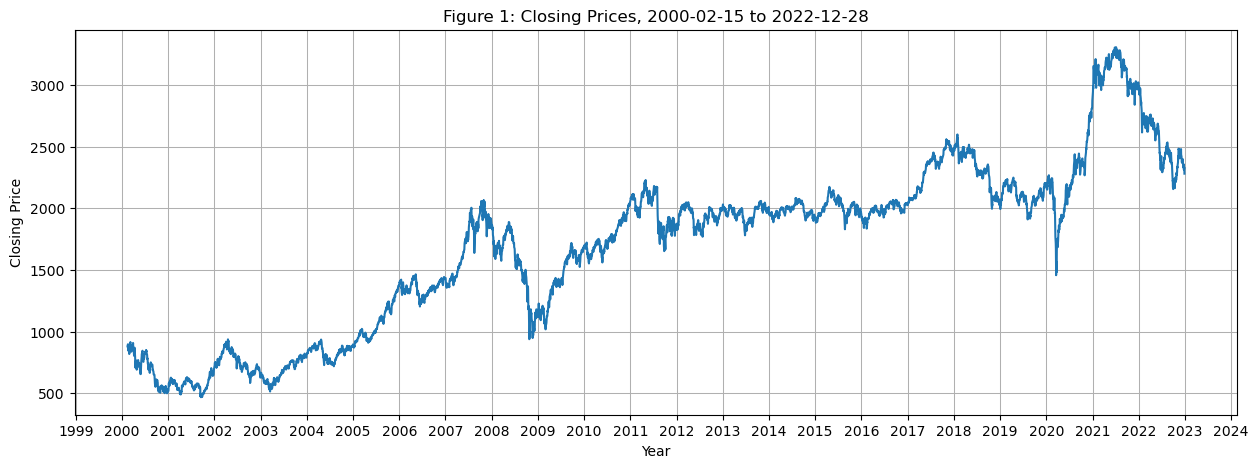

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df.index.date, df['Close'])
ax.set(xlabel='Year',ylabel='Closing Price',
title='Figure 1: Closing Prices, 2000-02-15 to 2022-12-28')
#only adding year labels to the X axis for clarity
ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.grid(linewidth = 0.75)
plt.show()

The closing prices of the index have increased consistently since the year 2000, but we canobserve some drops in prices. Some fit the timeline of globally relevant historical events such as9/11, the 2008 recession, and the Covid-19 pandemic.

Now let's take a closer look at the closing price compared to the traded volume for the last two years of available data

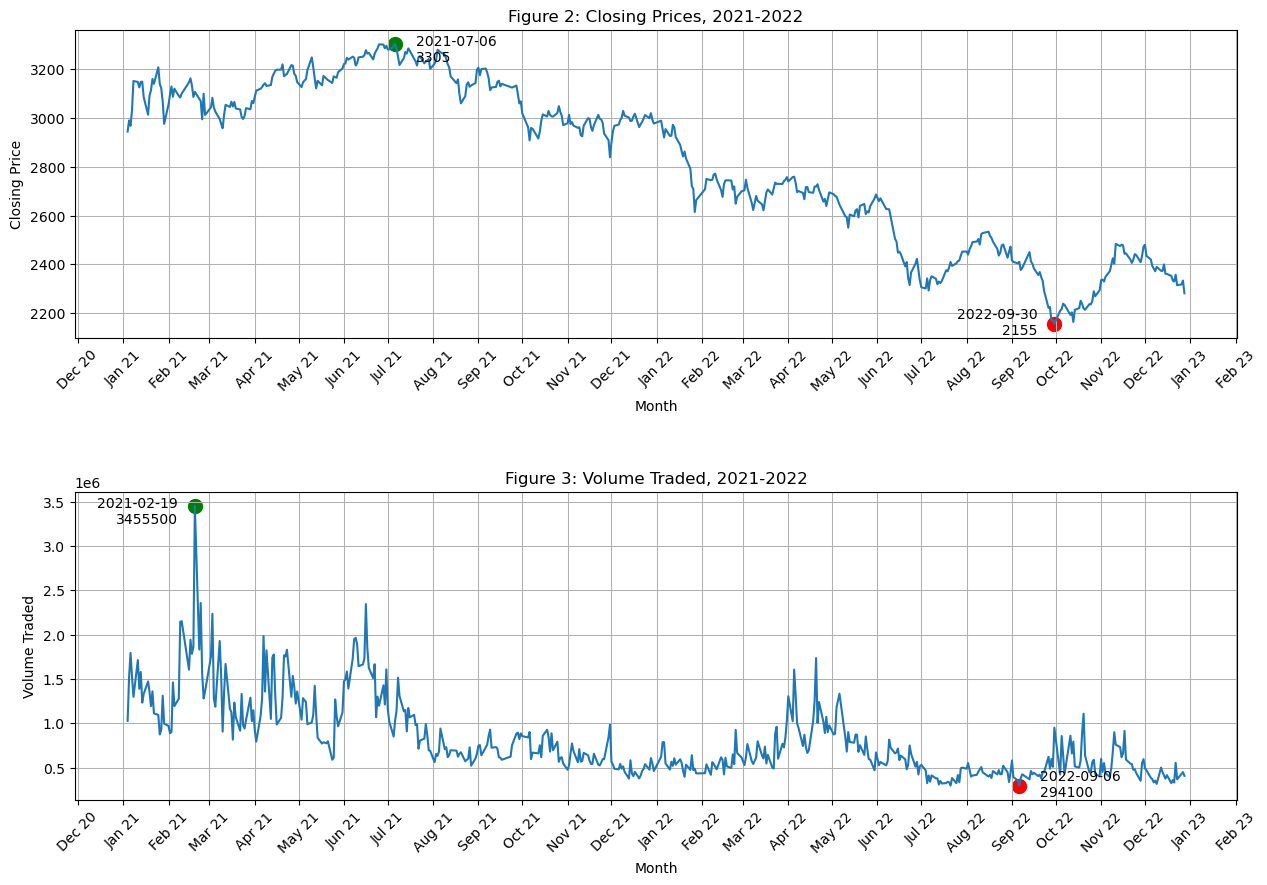

In [24]:
#(2) Your code goes here

# filter the data for the right years
df0708 = df[(df['Year'] >= 2021) & (df['Year'] <= 2022)] 

#identify max & min 
max_close = df0708[(df0708['Close'] == max(df0708['Close']))]
min_close = df0708[(df0708['Close'] == min(df0708['Close']))]
max_vol = df0708[(df0708['Volume'] == max(df0708['Volume']))]
min_vol = df0708[(df0708['Volume'] == min(df0708['Volume']))]

# create figure and axes objects
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# plot line plot and scatter plots for Close
axes[0].plot(df0708.index.date, df0708['Close'])
axes[0].scatter(max_close.index.date, max_close['Close'], color='green', s=100)
axes[0].scatter(min_close.index.date, min_close['Close'], color='red', s=100)

# set x and y axis labels, title, and grid for the first plot
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Closing Price')
axes[0].set_title('Figure 2: Closing Prices, 2021-2022')
axes[0].xaxis.set_major_locator(MonthLocator())
axes[0].xaxis.set_major_formatter(DateFormatter('%b %y'))
axes[0].tick_params(axis = 'x', rotation=45)
axes[0].grid(linewidth = 0.75)

# plot line plot and scatter plots for Volume
axes[1].plot(df0708.index.date, df0708['Volume'])
axes[1].scatter(max_vol.index.date, max_vol['Volume'], color='green', s=100)
axes[1].scatter(min_vol.index.date, min_vol['Volume'], color='red', s=100)

# set x and y axis labels, title, and grid for the second plot
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Volume Traded')
axes[1].set_title('Figure 3: Volume Traded, 2021-2022')
axes[1].xaxis.set_major_locator(MonthLocator())
axes[1].xaxis.set_major_formatter(DateFormatter('%b %y'))
axes[1].tick_params(axis = 'x', rotation=45)
axes[1].grid(linewidth = 0.75)

# add annotations for max and min points
axes[0].annotate(f'{max_close.index[0].date()}\n{int(max_close["Close"][0])}',
                 xy=(max_close.index.date, max_close['Close']),xytext=(+15, -13), 
                 textcoords='offset points', ha='left', fontsize=10)
axes[0].annotate(f'{min_close.index[0].date()}\n{int(min_close["Close"][0])}',
                 xy=(min_close.index.date, min_close['Close']), xytext=(-12, -8),
                 textcoords='offset points', ha='right', fontsize=10 )
axes[1].annotate(f'{max_vol.index[0].date()}\n{int(max_vol["Volume"][0])}',
                 xy=(max_vol.index.date, max_vol['Volume']), xytext=(-12, -13),
                 textcoords='offset points', ha='right', fontsize=10)
axes[1].annotate(f'{min_vol.index[0].date()}\n{int(min_vol["Volume"][0])}',
                 xy=(min_vol.index.date, min_vol['Volume']), xytext=(15, -8),
                 textcoords='offset points', ha='left', fontsize=10)


plt.show()

The highest Closing Price was observed on July 6, 2021, and the lowest on September 30, 2022.
In terms of Volume, the highest volume was observed on February 19, 2021 and the lowest on September 6, 2022.
There seems to be a general negative trend both in Closing Price and Volume.

Now let's analyze the relationship between variables:

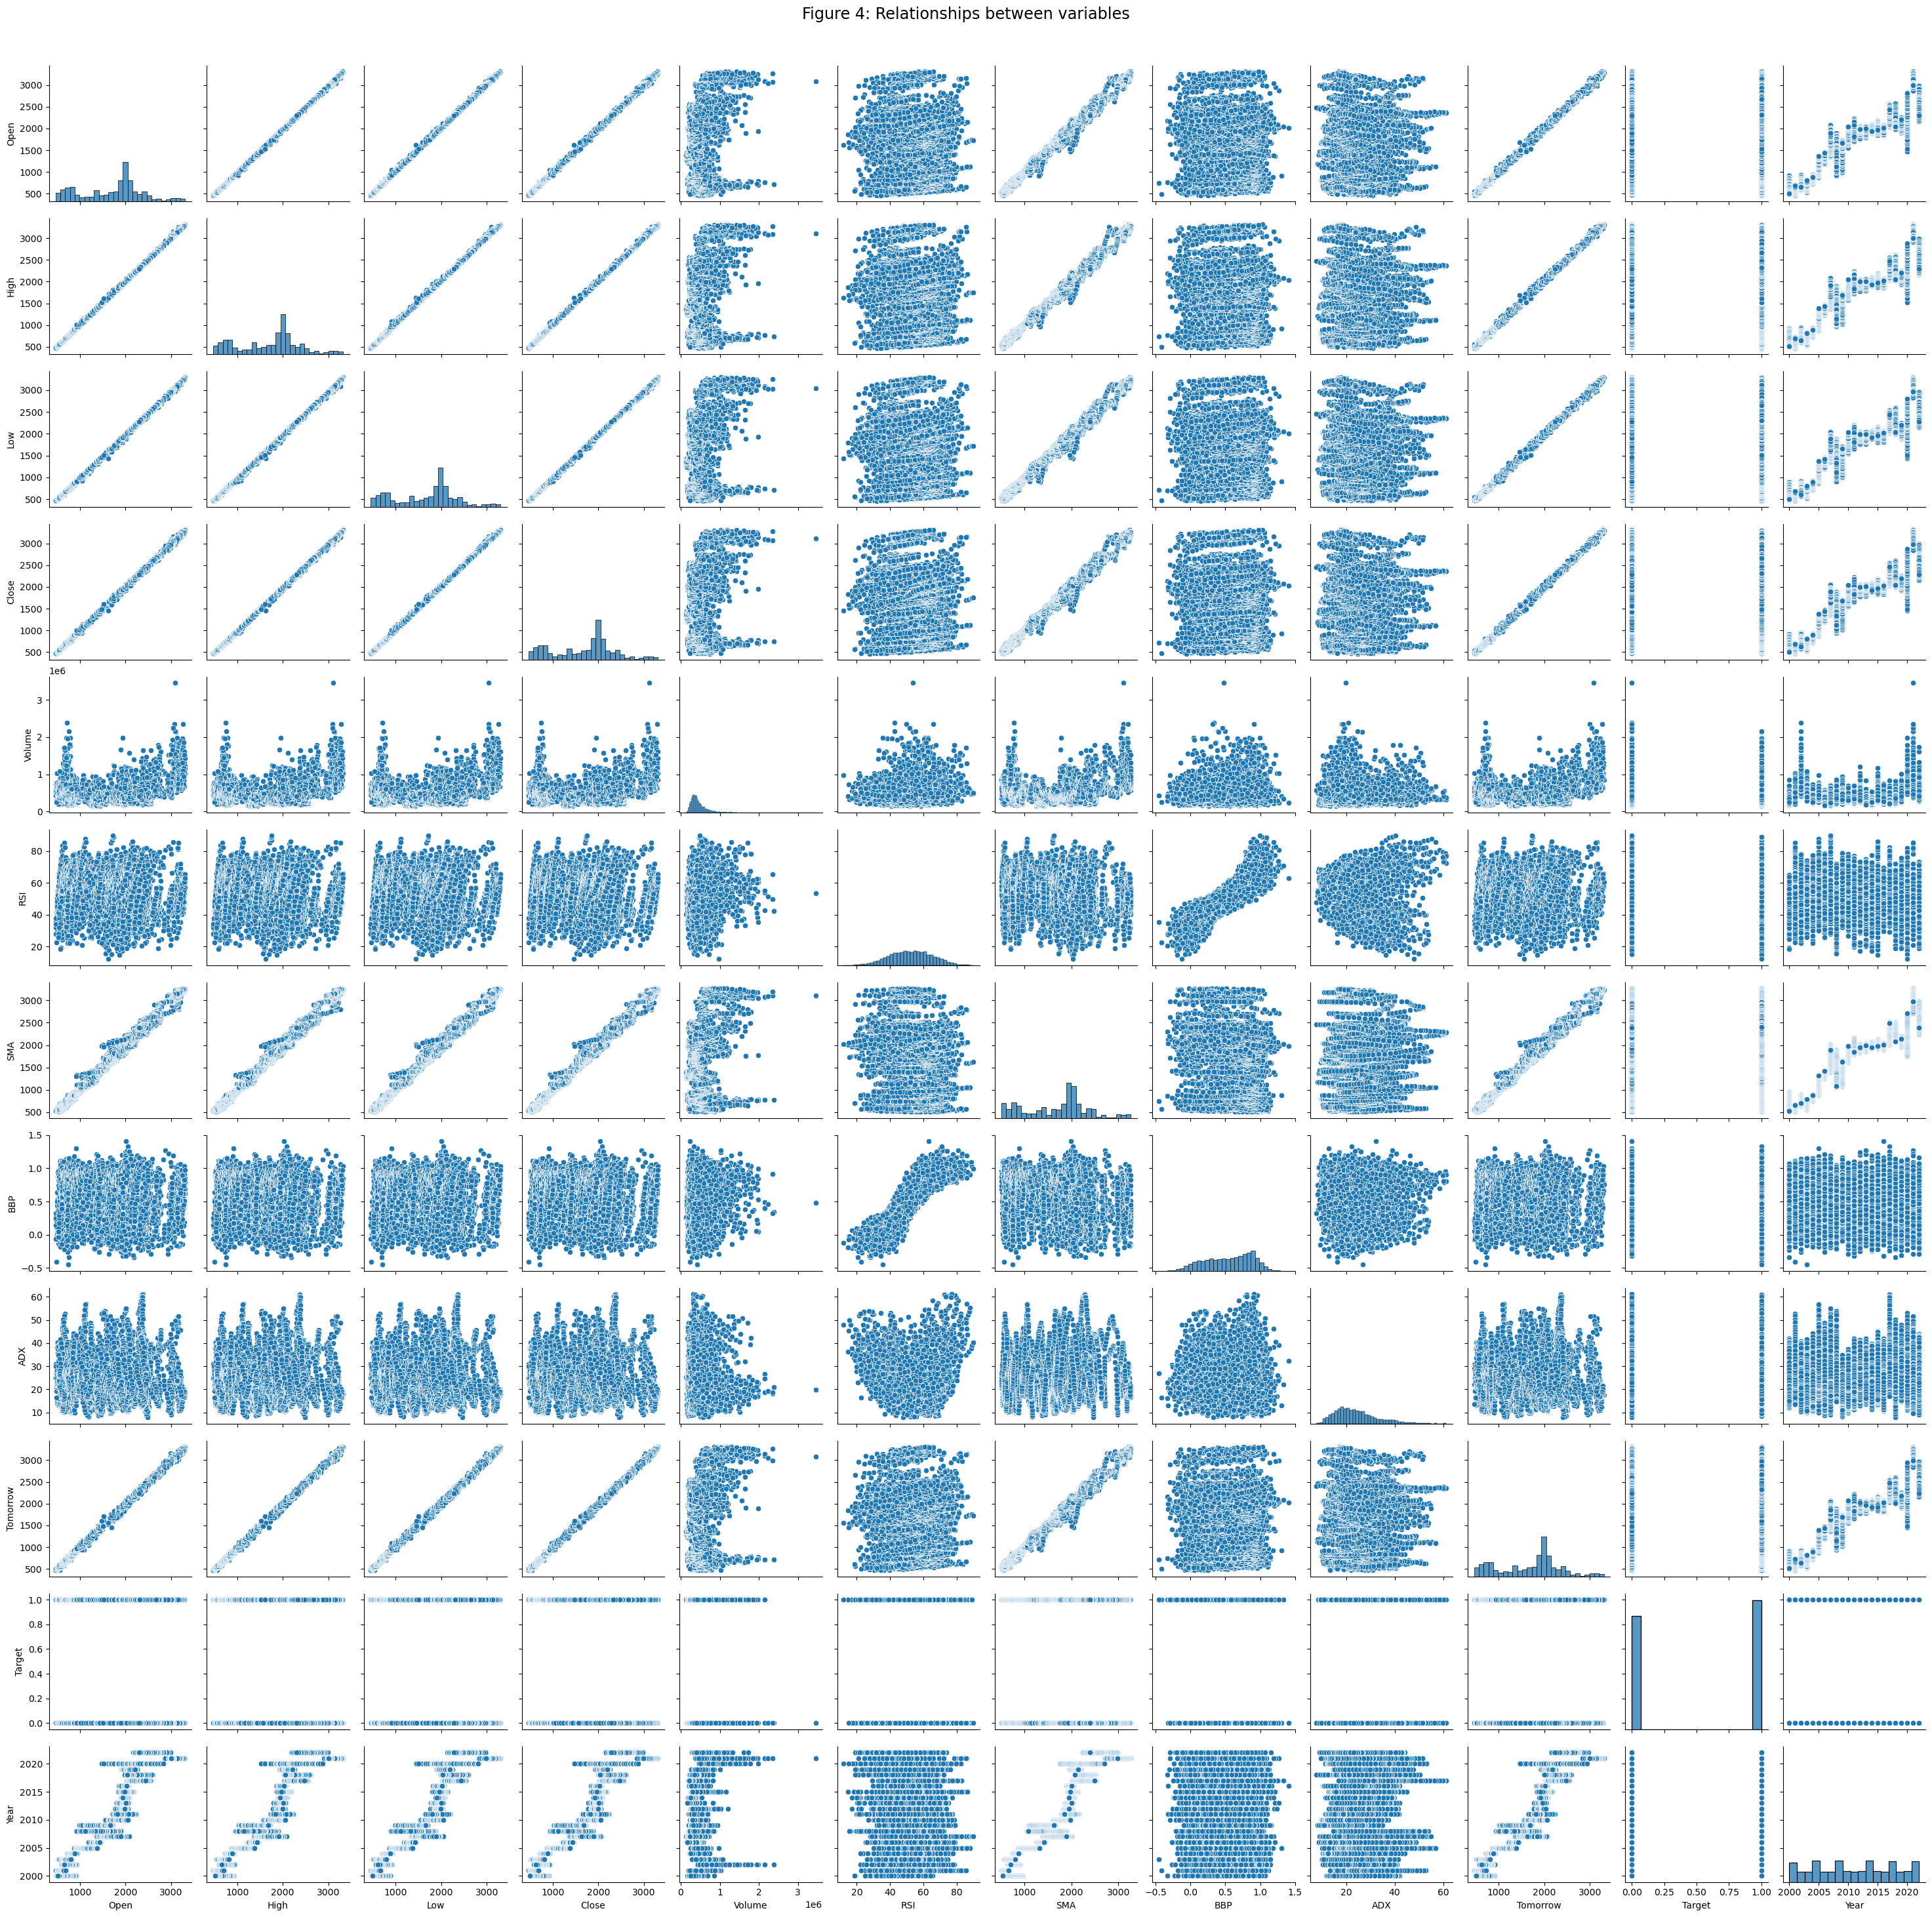

In [25]:
sns.pairplot(df)
plt.suptitle('Figure 4: Relationships between variables', size='xx-large')
plt.subplots_adjust(top=0.95)
plt.show()

In [26]:
df.drop('Year', axis=1).corr().round(3)

Open   High    Low  Close  Volume    RSI    SMA    BBP    ADX  \
Open      1.000  1.000  1.000  1.000   0.186  0.032  0.996  0.009 -0.038   
High      1.000  1.000  1.000  1.000   0.189  0.032  0.996  0.010 -0.036   
Low       1.000  1.000  1.000  1.000   0.184  0.038  0.995  0.017 -0.041   
Close     1.000  1.000  1.000  1.000   0.186  0.038  0.995  0.017 -0.038   
Volume    0.186  0.189  0.184  0.186   1.000  0.124  0.171  0.088  0.028   
RSI       0.032  0.032  0.038  0.038   0.124  1.000 -0.048  0.898 -0.012   
SMA       0.996  0.996  0.995  0.995   0.171 -0.048  1.000 -0.059 -0.026   
BBP       0.009  0.010  0.017  0.017   0.088  0.898 -0.059  1.000 -0.042   
ADX      -0.038 -0.036 -0.041 -0.038   0.028 -0.012 -0.026 -0.042  1.000   
Tomorrow  0.999  0.999  0.999  1.000   0.186  0.039  0.995  0.018 -0.037   
Target   -0.018 -0.018 -0.019 -0.019  -0.001  0.009 -0.020  0.015  0.013   

          Tomorrow  Target  
Open         0.999  -0.018  
High         0.999  -0.018  
Low          0.999  -0.019  
Close        1.000  -0.019  
Volume       0.186  -0.001  
RSI          0.039   0.009  
SMA          0.995  -0.020  
BBP          0.018   0.015  
ADX         -0.037   0.013  
Tomorrow     1.000   0.003  
Target       0.003   1.000

The variables Open, High, Low, and Close are strongly positively correlated, with correlation
coefficients of approximately 1. This can be visually verified by examining the pairplot of the
data. Furthermore, we note that the technical indicator SMA (Simple Moving Average) is strongly
correlated with the Open, High, Low, and Close variables. The Traded Volume variable does not
appear to have a significant effect on prices. The Tomorrow variable is strongly correlated with
Open, High, Low, and Close. This is to be expected, as Tomorrow is essentially a prediction of the
next day’s prices based on the current day’s data. No other strong correlations are evident.

## Predicting with Linear Regression

Let's try to predict Tomorrow from the SMA indicator. I will use the first 80% of the data for training andthe rest 20% for testing.

In [31]:
X = df['SMA'].values
y = df['Tomorrow'].values
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=0, shuffle=False)
#check data size
print(f'Number of instances in X: {X.shape[0]}')
print(f'Number of instances in X_train: {X_train.shape[0]}')
print(f'Number of instances in X_train: {y_train.shape[0]}')
print(f'Number of instances in X_test: {X_test.shape[0]}')
print(f'Number of instances in X_train and X_test together: {X_train.shape[0]+X_test.shape[0] }')
#fit and predict
lm = LinearRegression()
lm.fit(X_train.reshape(-1, 1), y_train)
y_pred = lm.predict(X_test.reshape(-1, 1))
#R2 score and parameters
print('R2_score:', r2_score(y_test, y_pred).round(3))
print('The regression coefficient for the "SMA" feature is:', lm.coef_[0].round(3))
print('The intercept is:', lm.intercept_.round(3))

Number of instances in X: 5642
Number of instances in X_train: 4513
Number of instances in X_train: 4513
Number of instances in X_test: 1129
Number of instances in X_train and X_test together: 5642
R2_score: 0.94
The regression coefficient for the "SMA" feature is: 1.001
The intercept is: 4.342


In [32]:
#Report root mean-square error
RMSE_test = mean_squared_error(y_test, y_pred, squared = False)
RMSE_train = mean_squared_error(y_train, lm.predict(X_train.reshape(-1, 1)), squared = False)
print('RMSE for the test set is:', RMSE_test.round(3))
print('RMSE for the training set is:', RMSE_train.round(3))

RMSE for the test set is: 101.808
RMSE for the training set is: 57.84


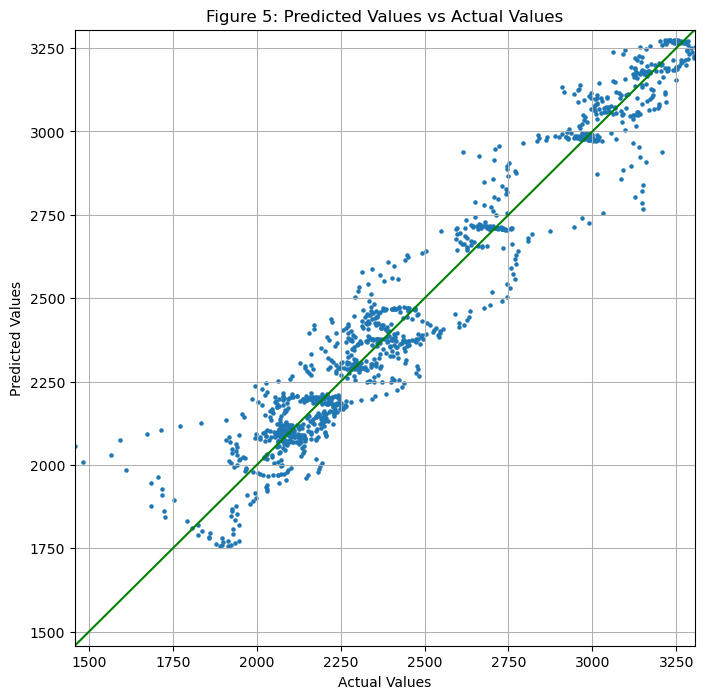

In [33]:
#Plot predicted vs actual values 
plt.figure(figsize=(8, 8))
plt.scatter(x = y_test, y = y_pred, s = 5)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], color = 'green')
plt.xlabel('Actual Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylabel('Predicted Values')
plt.ylim(y_test.min(), y_test.max())
plt.title('Figure 5: Predicted Values vs Actual Values')
plt.grid(linewidth = 0.75)
plt.show()

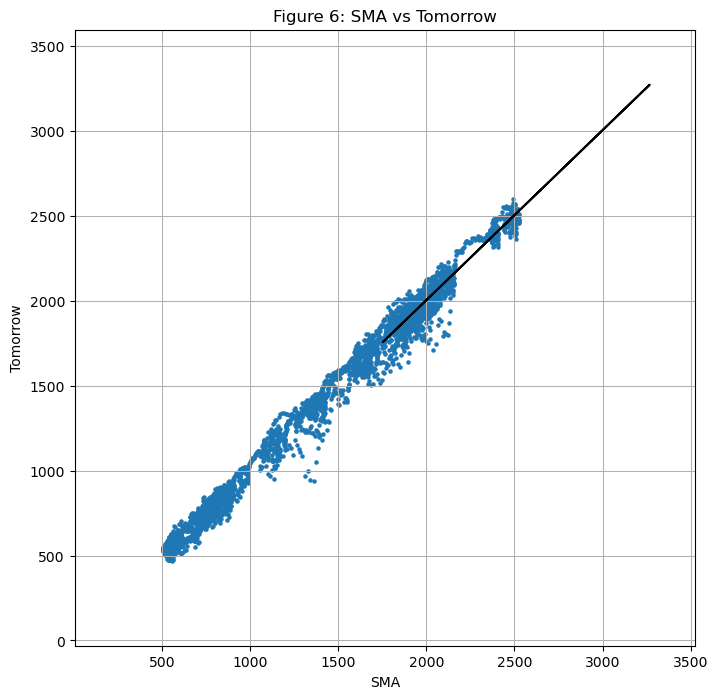

In [35]:
#Plot training data and regression line
plt.figure(figsize=(8, 8))
plt.scatter(x = X_train, y = y_train, s = 5)
plt.plot(X_test, y_pred, color = 'black')
plt.xlabel('SMA')
plt.xlim(X_train.min()-500, X_train.max()+1000)
plt.ylabel('Tomorrow')
plt.ylim(y_train.min()-500, y_train.max()+1000)
plt.title('Figure 6: SMA vs Tomorrow')
plt.grid(linewidth = 0.75)
plt.show()

equal to x, plus the intercept offset. This makes sense intuitively, since the SMA indicator is thesimple moving average of prices. Based on what observed in the correlation matrix, the two variables are strongly correlated, which can lead to problems of multicollinearity andtherefore make our model useless. It is not surprising that our R2 score is also very high (0.94). R2score, or coefficient of determination, is used to evaluate a model, and calculated as the varianceexplained by the model versus the total variance.
Root-Mean Squared Error (RMSE) results are a little less straightforward. RMSE measures thedifference between predicted values and actual values, and therefore its interpretation depends onthe context, and on the range of values. Our ‘Tomorrow’ values range from 468 to 3305, and ourRMSE for the test set is approximately 102 - which is quite high for lower values, but not for thehigher range. What is interesting to see though is that the RMSE on the training set is muchlower, at approximately 58, which could suggest that the model is overfitting to the training data.18.

## Predicting with Multiple Linear Regression and Polynomial Regression

Let's try to predict Tomorrow using all indicators using a multiple Linear Regression and a Polynomial Regressionb, and then compare the two. Again, I will use the first 80% of the data for training and
the rest 20% for testing.

In [38]:
#Multiple Linear Regression

ind_var = ['RSI', 'SMA', 'BBP', 'ADX']
X = df[ind_var].values
y = df['Tomorrow'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, shuffle=False)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('R2_score:', r2_score(y_test, y_pred).round(3))
print('The intercept is:', lm.intercept_.round(3))


lm_coeff = [f'{ind_var[i]}: {lm.coef_[i]:.3f}' for i in range(len(ind_var))]
print('The coefficients are:', lm_coeff)

RMSE_test = mean_squared_error(y_test, y_pred, squared = False)
RMSE_train = mean_squared_error(y_train, lm.predict(X_train), squared = False)

   
print('RMSE for the test set is:', RMSE_test.round(3))
print('RMSE for the training set is:', RMSE_train.round(3))



R2_score: 0.979
The intercept is: -189.829
The coefficients are: ['RSI: 4.122', 'SMA: 0.999', 'BBP: -3.852', 'ADX: -0.798']
RMSE for the test set is: 59.725
RMSE for the training set is: 29.344


In [39]:
#Polynomial Regression

pf = PolynomialFeatures(degree=2, include_bias=False)

pm_X_train = pf.fit_transform(X_train)
pm_X_test = pf.fit_transform(X_test)

pm = LinearRegression()
pm.fit(pm_X_train, y_train)


y_pred = pm.predict(pm_X_test)

print('R2_score:', r2_score(y_test, y_pred).round(3))
print('The intercept is:', pm.intercept_.round(3))


pm_coeff = [f'{pm.coef_[i]:.3f}' for i in range(len(pm.coef_))]
print('The coefficients are:', pm_coeff)

RMSE_test = mean_squared_error(y_test, y_pred, squared = False)
RMSE_train = mean_squared_error(y_train, pm.predict(pm_X_train), squared = False)

print('RMSE for the test set is:', RMSE_test.round(3))
print('RMSE for the training set is:', RMSE_train.round(3))



R2_score: 0.984
The intercept is: -125.135
The coefficients are: ['2.847', '0.954', '76.494', '-1.737', '-0.012', '0.001', '-1.505', '0.052', '-0.000', '-0.010', '-0.000', '38.362', '-0.764', '-0.015']
RMSE for the test set is: 51.951
RMSE for the training set is: 27.987


Both Multiple Linear Regression and Polynomial Regression models have higher R2 scores than
the Simple Linear Regression model. The coefficients for Multiple Linear regression
show that RSI and BBP have a higher weight (Positive for RSI and Negative for BBP) in
determining “Tomorrow” than SMA and ADX do.
Polynomial regression model perform better than simple linear regression model and multiple linear
regression model. It has the highest R2 score and lowest RMSE for both test set and training set.
We can also consider it more reliable than the previous Linear Regression, because it contains more
technical indicators that are not strongly correlated with ‘Tomorrow’. Two other things should be
noted:
1. The improvement between the multiple linear regression model and the polynomial regression
model is minimal, and polynomial regression model is more complicated. Further analysis is
needed to determine the best model fit, as the tradeoff between simplicity and performance
is important in machine learning.
2. The difference in RMSE for test set and training set is still high in these two new models,
which still could suggest overfitting.

## Predicting with Classification

Let's now consider the prediction of stock price movement as a binary classification
problem - class 1 for upward movement and class 0 otherwise. We use the four technical Indicators,
‘RSI’, ‘SMA’, ‘BBP’, ‘ADX’, as input features to a classifier to predict ‘Target’. Using 10-fold cross validation with no shuffling, I will train four classifiers: Logistic Regression, SVM, Decision Trees, and Random Forests. I will compare the accuracy of each of them. 

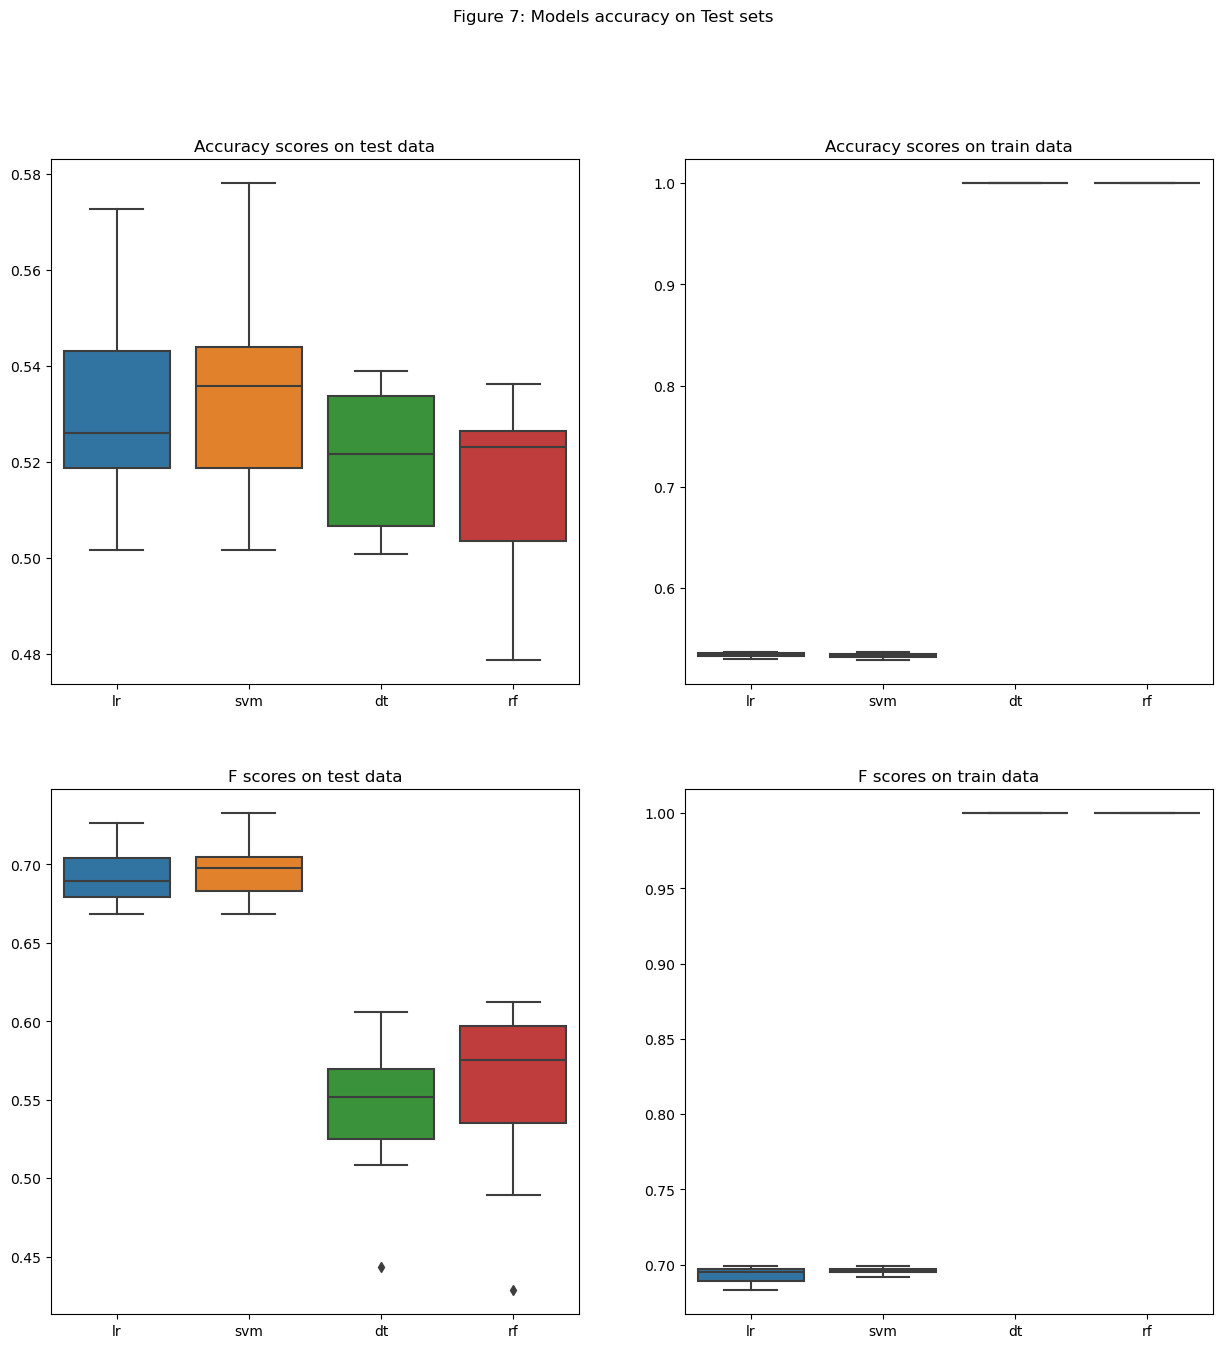

Test Accuracy  Train Accuracy    Test F   Train F
lr        0.530665        0.534168  0.692347  0.692832
svm       0.533502        0.533499  0.695529  0.695790
dt        0.520740        1.000000  0.543524  1.000000
rf        0.514883        1.000000  0.555923  1.000000

In [41]:
X = df[['RSI', 'SMA', 'BBP', 'ADX']]
y = df['Target']

kf = KFold(n_splits = 10, shuffle = False)

#dictionary of the classifiers for loop
classifiers = {
    'lr': LogisticRegression(random_state=0),
    'svm': SVC(random_state=0),
    'dt': DecisionTreeClassifier(random_state=0),
    'rf': RandomForestClassifier(random_state=0)
}

#dictionary for test accuracy & F scores
test_ascores = {}
test_fscores = {}

#loop over classifiers to get test accuracy & Fscores
for classifier_name, classifier in classifiers.items():
    test_ascores[classifier_name] = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
    test_fscores[classifier_name] = cross_val_score(classifier, X, y, cv=kf, scoring='f1')


#dictionary for train accuracy & F scores
train_ascores = {}
train_fscores = {}

#loop over classifiers to fit/predict train scores and get train accuracy & F scores
for classifier_name, classifier in classifiers.items():
    train_ascores[classifier_name] = []
    train_fscores[classifier_name] = []
    for train_index , test_index in kf.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        classifier.fit(X_train, y_train)
        pred_values = classifier.predict(X_train)

        accuracy = accuracy_score(pred_values , y_train)
        train_ascores[classifier_name].append(accuracy)
        
        f = f1_score(pred_values , y_train)
        train_fscores[classifier_name].append(f)
        

#boxplots of test_scores

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Figure 7: Models accuracy on Test sets', size='large')

sns.boxplot(ax = axes[0,0], data = list(test_ascores.values()))
axes[0,0].set(title='Accuracy scores on test data')
axes[0,0].set_xticklabels(list(test_ascores.keys()))

sns.boxplot(ax = axes[0,1],data = list(train_ascores.values()))
axes[0,1].set(title='Accuracy scores on train data')
axes[0,1].set_xticklabels(list(train_ascores.keys()))

sns.boxplot(ax = axes[1,0],data = list(test_fscores.values()))
axes[1,0].set(title='F scores on test data')
axes[1,0].set_xticklabels(list(test_fscores.keys()))

sns.boxplot(ax = axes[1,1],data = list(train_fscores.values()))
axes[1,1].set(title='F scores on train data')
axes[1,1].set_xticklabels(list(train_fscores.keys()))

plt.show()

#mean accuracy and mean F-score

score_means = pd.DataFrame()
score_means.index = classifiers.keys()
score_means['Test Accuracy'] = {key: statistics.mean(values) for key, values in test_ascores.items()}.values()
score_means['Train Accuracy'] = {key: statistics.mean(values) for key, values in train_ascores.items()}.values()
score_means['Test F'] = {key: statistics.mean(values) for key, values in test_fscores.items()}.values()
score_means['Train F'] = {key: statistics.mean(values) for key, values in train_fscores.items()}.values()

score_means

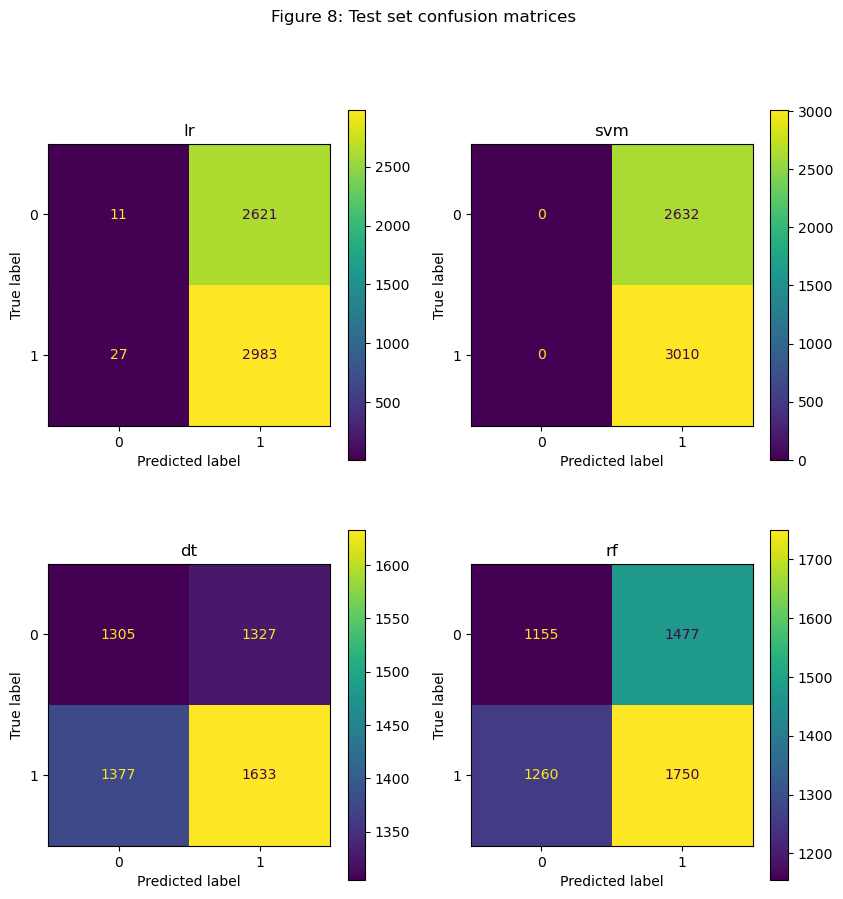

In [42]:
#display the confusion matrix for the validation sets


total_cm = {classifier_name: np.zeros((2,2), dtype = int) for classifier_name in classifiers.keys()}


for classifier_name, classifier in classifiers.items():
    train_ascores[classifier_name] = []
    train_fscores[classifier_name] = []
    for train_index , test_index in kf.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        total_cm[classifier_name] += cm
        
        
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Figure 8: Test set confusion matrices', size='large')
for ax, classifier_name in zip(axes.flatten(), total_cm.keys()):
    cm = total_cm[classifier_name]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax)
    ax.set_title(classifier_name) 
    ax.grid(False)
plt.show()
       

None of the classifiers performs particularly well.

To evaluate the performance of the classifiers we use two metrics, the Accuracy score and the F score. The Accuracy score is the proportion of correctly classified instances. The F score represents the mean between precision and recall, where precision is the proportion of true positives over all predicted positives and recall is the proportion of true positives over "real positives", i.e. true positives and false negatives. Generally speaking, the higher these scores are the better.

Logistic Regression predicted most "Target"s to be 1 (i.e. "Tomorrow" to be higher than "Close"), with an accuracy of approximately 0.53 and a F score of approximately 0.69 on both Test and Train data. SVM predicted all "Target"s to be 1, having an accuracy of approximately 0.53 and a F score of approximately 0.7 on both Test and Train data. These scores suggest underfitting for Logistic Regression and SVM. Decision Tree and Random forests have a relatively even split of True Positives, True Negatives, False Positives and False negatives. Their accuracy ascore is approximately 0.52 on Test data, and 0.54 and 0.56 respectively on Train data. For both models, F scores are 1 for Train data, which suggests overfitting.

### Applying dimensionality reduction

Let's now try to perform perform dimensionality reduction with PCA to the data and run classification experiments on the dimensionality reduced data. I will to find the minimum set of principal components that explains at least 95% of the variance of the data. Then, I will run the same for classifiers as in the previous section, using dimensionality-reduced principal components. 

In [44]:
#find number of components
X = df[['RSI', 'SMA', 'BBP', 'ADX']]
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)

pca.n_components_

1

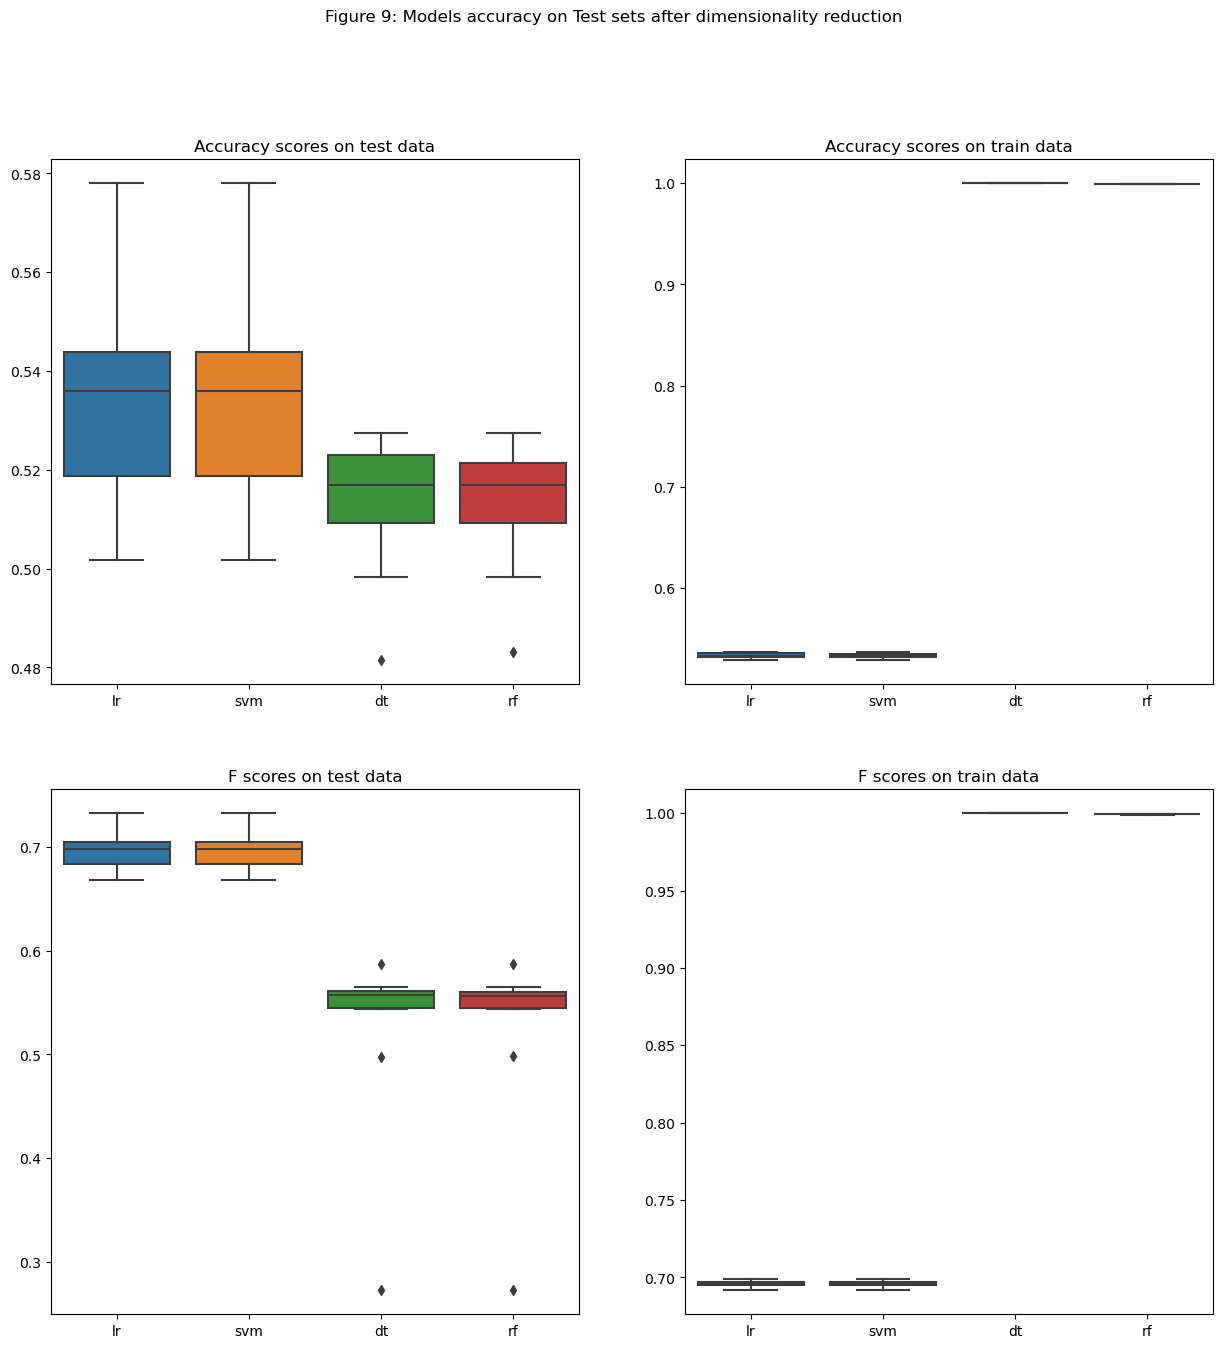

Test Accuracy  Train Accuracy    Test F   Train F
lr        0.533502        0.533578  0.695529  0.695740
svm       0.533502        0.533499  0.695529  0.695790
dt        0.513651        1.000000  0.524656  1.000000
rf        0.513473        0.999429  0.524270  0.999465

In [45]:
#run the classifiers
#(2) Your code goes here
X = pd.DataFrame(X_reduced, columns = ['PCA'])
y = df['Target']

kf = KFold(n_splits = 10, shuffle = False)

#create a dictionary of the classifiers for loop

classifiers = {
    'lr': LogisticRegression(random_state=0),
    'svm': SVC(random_state=0),
    'dt': DecisionTreeClassifier(random_state=0),
    'rf': RandomForestClassifier(random_state=0)
}

#dictionary for test accuracy & F scores
test_ascores_pca = {}
test_fscores_pca = {}

#loop over classifiers to get test accuracy & Fscores
for classifier_name, classifier in classifiers.items():
    test_ascores_pca[classifier_name] = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
    test_fscores_pca[classifier_name] = cross_val_score(classifier, X, y, cv=kf, scoring='f1')


#dictionary for train accuracy & F scores
train_ascores_pca = {}
train_fscores_pca = {}

#loop over classifiers to fit/predict train scores and get train accuracy & F scores
for classifier_name, classifier in classifiers.items():
    train_ascores_pca[classifier_name] = []
    train_fscores_pca[classifier_name] = []
    for train_index , test_index in kf.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        classifier.fit(X_train, y_train)
        pred_values = classifier.predict(X_train)

        accuracy = accuracy_score(pred_values , y_train)
        train_ascores_pca[classifier_name].append(accuracy)
        
        f = f1_score(pred_values , y_train)
        train_fscores_pca[classifier_name].append(f)


#boxplots of test_scores

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Figure 9: Models accuracy on Test sets after dimensionality reduction', size='large')

sns.boxplot(ax = axes[0,0], data = list(test_ascores_pca.values()))
axes[0,0].set(title='Accuracy scores on test data')
axes[0,0].set_xticklabels(list(test_ascores_pca.keys()))

sns.boxplot(ax = axes[0,1],data = list(train_ascores_pca.values()))
axes[0,1].set(title='Accuracy scores on train data')
axes[0,1].set_xticklabels(list(train_ascores_pca.keys()))


sns.boxplot(ax = axes[1,0],data = list(test_fscores_pca.values()))
axes[1,0].set(title='F scores on test data')
axes[1,0].set_xticklabels(list(test_fscores_pca.keys()))


sns.boxplot(ax = axes[1,1],data = list(train_fscores_pca.values()))
axes[1,1].set(title='F scores on train data')
axes[1,1].set_xticklabels(list(train_fscores_pca.keys()))

plt.show()

#mean accuracy and mean F-score

score_means_pca = pd.DataFrame()
score_means_pca.index = classifiers.keys()
score_means_pca['Test Accuracy'] = {key: statistics.mean(values) for key, values in test_ascores_pca.items()}.values()
score_means_pca['Train Accuracy'] = {key: statistics.mean(values) for key, values in train_ascores_pca.items()}.values()
score_means_pca['Test F'] = {key: statistics.mean(values) for key, values in test_fscores_pca.items()}.values()
score_means_pca['Train F'] = {key: statistics.mean(values) for key, values in train_fscores_pca.items()}.values()

score_means_pca



PCA returned one principal component to explain 95% of the variance of the data. Results of the 4 classification models run on the reduced data are virtually unchanged from running the model on unprocessed data. It could be insightful to try with a different number of components, or other transformation techniques.

### Experimenting with Support Vector Machines

Support Vector Machines (SVMs) are a popular class of algorithms used for
classification tasks. SVMs are powerful classification algorithms because they work with both linear
and nonlinear classification problems. Different kernel functions can be used with SVM. They define
how the algorithm maps features in the feature space. In the previous sections I used the default
kernel function in SVC, which is the Radial Basis Function (RBF). However, there are other kernel
functions that can be used, such as the Linear kernel and Polynomial kernel. My hypothesis is that
using a different kernel function may lead to better classification performance. Therefore, in my
experiment, I will try out different kernel functions to identify which kernel performs best on the
dataset.

In [48]:
X = df[['RSI', 'SMA', 'BBP', 'ADX']]
y = df['Target']

kf = KFold(n_splits = 10, shuffle = False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, shuffle=False)


# Define possible parameters
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# Define SVM model
svm = SVC(random_state=0)

# Perform grid search
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Evaluate performance on test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Validation accuracy:', accuracy)

# Get best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)


Validation accuracy: 0.5367581930912312
Best hyperparameters: {'kernel': 'poly'}


Grid Search shows that polynomial kernels are best performing. Initially, as polynomial kernels support different polynomial degrees, I intended to include polynomial degrees in the Grid Search, but this approach proved computationally expensive. I therefore decided to limit the Grid Search to kernel types. The results indicated that the optimal kernel would be polynomial. I will then experiment with SVMs with 2nd, 3rd, and 4th degree polynomial kernel functions. 

In [49]:
#determine best degree polynomial
svms = {
    'svm_poly2': SVC(kernel='poly', degree=2, random_state=0),
    'svm_poly3': SVC(kernel='poly', degree=3, random_state=0),
    'svm_poly4': SVC(kernel='poly', degree=4, random_state=0)  
}

#generate test scores
test_ascores_exp = {}
test_fscores_exp = {}

for model_name, model in svms.items():
    test_ascores_exp[model_name] = []
    test_fscores_exp[model_name] = []
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred , y_test)
    test_ascores_exp[model_name].append(accuracy)
    F_score = f1_score(y_pred , y_test)
    test_fscores_exp[model_name].append(F_score)

#generate train scores
train_ascores_exp = {}
train_fscores_exp = {}

for model_name, model in svms.items():
    train_ascores_exp[model_name] = []
    train_fscores_exp[model_name] = []
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_pred , y_train)
    train_ascores_exp[model_name].append(accuracy)
    F_score = f1_score(y_pred , y_train)
    train_fscores_exp[model_name].append(F_score)

print('Test accuracy scores are:', {k: [round(x, 3) for x in v] for k, v in test_ascores_exp.items()})
print('Test F scores are:', {k: [round(x, 3) for x in v] for k, v in test_fscores_exp.items()})
print('Train accuracy scores are:', {k: [round(x, 3) for x in v] for k, v in train_ascores_exp.items()})
print('Train F scores are:', {k: [round(x, 3) for x in v] for k, v in train_fscores_exp.items()})


Test accuracy scores are: {'svm_poly2': [0.537], 'svm_poly3': [0.537], 'svm_poly4': [0.537]}
Test F scores are: {'svm_poly2': [0.699], 'svm_poly3': [0.699], 'svm_poly4': [0.699]}
Train accuracy scores are: {'svm_poly2': [0.533], 'svm_poly3': [0.533], 'svm_poly4': [0.533]}
Train F scores are: {'svm_poly2': [0.695], 'svm_poly3': [0.695], 'svm_poly4': [0.695]}


Results are identical across all degree polynomials. Let's compare accuracy and F scores from the previous model, using RBF, with the ones of our current model, based on the polynomial kernel. 

In [50]:
#compare with previous results

#retrieve accuracy and F scores from question previous model
svm1_ascores = [ score_means.loc['svm']['Test Accuracy'] , score_means.loc['svm']['Train Accuracy'] ]
svm1_fscores = [ score_means.loc['svm']['Test F'] , score_means.loc['svm']['Train F'] ]

#retrieve accuracy and F scores from current model
svm2_ascores = [ train_ascores_exp['svm_poly2'][0] , test_ascores_exp['svm_poly2'][0] ]
svm2_fscores = [ train_fscores_exp['svm_poly2'][0] , train_fscores_exp['svm_poly2'][0] ]

#perform a t-test on accuracy scores
t_statistic_a, p_value_a = stats.ttest_rel(svm2_ascores, svm1_ascores)
print('p-value accuracy scores:', p_value_a.round(3))

#perform a t-test on F scores scores
t_statistic_f, p_value_b = stats.ttest_rel(svm2_fscores, svm1_fscores)
print('p-value F scores:', p_value_b.round(3))


if p_value_a < 0.05: 
    print('The difference in accuracy between the models is statistically significant.') 
else: 
    print('The difference in accuracy between the models is not statistically significant.')  

if p_value_b < 0.05: 
    print('The difference in F scores between the models is statistically significant.') 
else: 
    print('The difference in F scores between the models is not statistically significant.')


p-value accuracy scores: 0.657
p-value F scores: 0.145
The difference in accuracy between the models is not statistically significant.
The difference in F scores between the models is not statistically significant.


Improvements in scores achieved with this model compared to the previous model are not statistically significant. 